# oct-image-enhancement-optimisation
### CITS4404 Assignment 2 @ The University of Western Australia

Alian Haidar (22900426)\
Conan Dewitt (22877792)\
Dennis Gunadi (22374535)\
Lili Liu (23212326)

This project attempt presents the optimisation of a Camo Worm based image enhancement algorithm, specifically in the context of optical coherence tomography.

Import the necessary modules:

In [8]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import imageio.v3 as iio

Include the custom [worm.py](worm.py) module for visualisation:

In [9]:
import worm as wrm

Define global variables:

In [10]:
rng = np.random.default_rng()
Path = mpath.Path

mpl.rcParams['figure.dpi']= 72  # size of image

POPULATION_SIZE = 40
IMAGE_DIR = 'images'
IMAGE_NAME = 'original'
MASK = [320, 560, 160, 880]  # y_min, y_max, x_min, x_max

Read, resize and display the input image:

Image name:     original
Image size:     240 720
Intensity max:  210
Intensity min:  0
Intensity mean: 49.3
Intensity std:  34.8


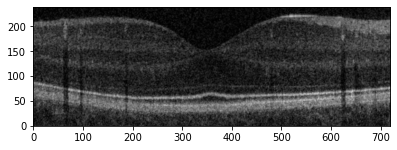

In [11]:
def crop(image, mask):
    h, w = np.shape(image)
    return image[max(mask[0],0):min(mask[1],h), max(mask[2],0):min(mask[3],w)]

def prep_image(imdir, imname, mask):
    image = np.flipud(crop(iio.imread(imdir+'/'+imname+".png"), mask))
    print("Image name:    ", imname)
    print("Image size:    ", *np.shape(image))
    print("Intensity max: ", np.max(image))
    print("Intensity min: ", np.min(image))
    print("Intensity mean:", round(np.mean(image), 1))
    print("Intensity std: ", round(np.std(image), 1))
    plt.imshow(image, vmin=0, vmax=255, cmap='gray', origin='lower')  # use vmin and vmax to stop imshow from scaling
    plt.show()
    return image

image = prep_image(IMAGE_DIR, IMAGE_NAME, MASK)

Present the Cost Function:

In [12]:
def calculate_cost(worm, image, other_worms):
    # Extract target colour
    target_colour = image[int(worm.y), int(worm.x)] / 255.0
    
    # Generate Bézier curve points
    x_points, y_points = worm.bezier_points()
    
    # Ensure points are within image boundaries
    x_points = np.clip(x_points, 0, image.shape[1]-1)
    y_points = np.clip(y_points, 0, image.shape[0]-1)
    
    # Calculate environment cost
    worm_pixels = image[y_points, x_points]
    environment_cost = np.mean(np.abs(worm_pixels - target_colour))
    
    # Calculate group knowledge cost
    position_cost = 0
    for other_worm in other_worms:
        if other_worm != worm:
            distance = np.sqrt((worm.x - other_worm.x)**2 + (worm.y - other_worm.y)**2)
            position_cost += distance

    # Calculate internal knowledge costs
    size_cost = worm.r
    
    p0 = (worm.x, worm.y)
    p1 = (worm.x + worm.dr * np.cos(worm.theta + worm.dgamma), 
          worm.y + worm.dr * np.sin(worm.theta + worm.dgamma))
    p2 = (worm.x + worm.r * np.cos(worm.theta), 
          worm.y + worm.r * np.sin(worm.theta))
    vector1 = np.array(p1) - np.array(p0)
    vector2 = np.array(p2) - np.array(p1)
    angle = np.arccos(np.dot(vector1, vector2) / (np.linalg.norm(vector1) * np.linalg.norm(vector2)))
    curvature_cost = angle
    
    color_cost = np.mean(np.abs(worm.colour - target_colour))

    # Combine costs
    total_cost = size_cost + curvature_cost + color_cost + position_cost + environment_cost
    return total_cost

Define the Worm Population, the *Genetic Function*:

In [13]:
class Worm_Population:
    # Initialize the Worm_Population object with a given size and image shape
    def __init__(self, size, image_shape):
        self.worms = [self.create_random_worm(image_shape) for _ in range(size)]
        self.image_shape = image_shape

    # Create a random worm with random attributes based on the given image shape
    def create_random_worm(self, image_shape):
        # Randomly generate attributes for the worm
        x = np.random.randint(0, image_shape[1])
        y = np.random.randint(0, image_shape[0])
        r = np.random.randint(10, 100)
        theta = np.random.rand() * 2 * np.pi
        deviation_r = np.random.randint(-50, 50)
        deviation_gamma = np.random.rand() * 2 * np.pi
        width = np.random.randint(1, 10)
        colour = np.random.rand()
        return wrm.Camo_Worm(x, y, r, theta, deviation_r, deviation_gamma, width, colour)

    # Evaluate the fitness of each worm in the population based on a given image and other worms
    def evaluate_fitness(self, image, other_worms):
        for worm in self.worms:
            worm.fitness = 1 / (1 + calculate_cost(worm, image, other_worms))

    # Select the fittest worms to survive and reproduce
    def select(self):
        self.worms.sort(key=lambda x: x.fitness, reverse=True)
        self.worms = self.worms[:len(self.worms)//2] * 2  # keep top 50% and duplicate to maintain population size

    # Perform crossover to generate a new generation of worms
    def crossover(self):
        new_generation = []
        while len(new_generation) < len(self.worms) * 2:
            if len(self.worms) >= 2:
                parent1, parent2 = np.random.choice(self.worms, 2, replace=False)  # Randomly select parents
                child1, child2 = self.mate(parent1, parent2)  # Generate children through crossover
                new_generation.extend([child1, child2])  # Add children to new generation
            else:
                break
        self.worms = new_generation[:len(self.worms)]  # Update population with new generation

    # Generate children by averaging attributes of two parent worms
    def mate(self, parent1, parent2):
        child1 = wrm.Camo_Worm(  # Create child 1
            (parent1.x + parent2.x) // 2,
            (parent1.y + parent2.y) // 2,
            (parent1.r + parent2.r) // 2,
            (parent1.theta + parent2.theta) / 2,
            (parent1.dr + parent2.dr) // 2,
            (parent1.dgamma + parent2.dgamma) / 2,
            (parent1.width + parent2.width) // 2,
            (parent1.colour + parent2.colour) / 2
        )
        child2 = wrm.Camo_Worm(  # Create child 2
            (parent1.x + parent2.x) // 2,
            (parent1.y + parent2.y) // 2,
            (parent1.r + parent2.r) // 2,
            (parent1.theta + parent2.theta) / 2,
            (parent1.dr + parent2.dr) // 2,
            (parent1.dgamma + parent2.dgamma) / 2,
            (parent1.width + parent2.width) // 2,
            (parent1.colour + parent2.colour) / 2
        )
        return child1, child2  # Return the generated children

Create the Camo Worm population about the input image, and visualise each generation:

Generation 1: 40 worms


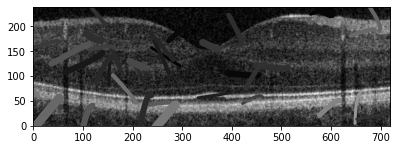

 Average Cost = 10242.44021800353
Generation 2: 40 worms


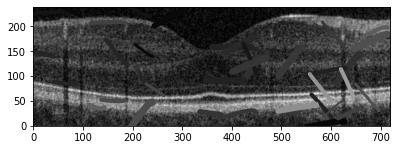

 Average Cost = nan
Generation 3: 40 worms


/var/folders/zy/vcpwmd2d5lgb3ltsd90_sl9w0000gn/T/ipykernel_25104/4238940654.py:33: RuntimeWarning: invalid value encountered in scalar divide
  angle = np.arccos(np.dot(vector1, vector2) / (np.linalg.norm(vector1) * np.linalg.norm(vector2)))


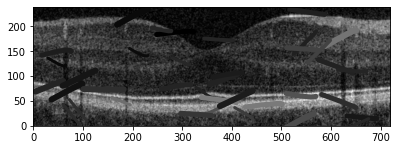

 Average Cost = nan
Generation 4: 40 worms


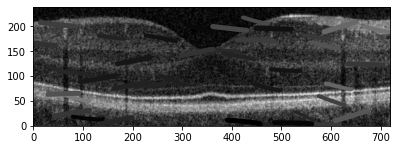

 Average Cost = nan
Generation 5: 40 worms


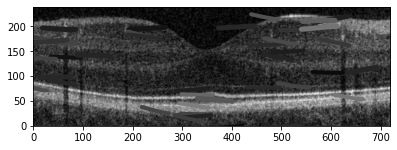

 Average Cost = nan
Generation 6: 40 worms


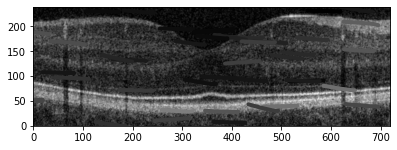

 Average Cost = nan
Generation 7: 40 worms


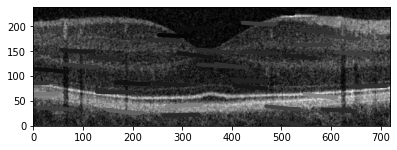

 Average Cost = 10479.994736517052
Generation 8: 40 worms


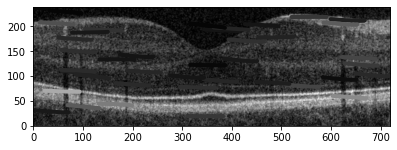

 Average Cost = 10692.069759308733
Generation 9: 40 worms


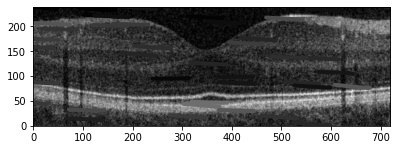

 Average Cost = 10633.96798266424
Generation 10: 40 worms


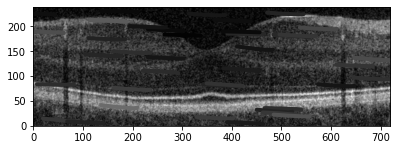

 Average Cost = 9977.646040745689
Generation 11: 40 worms


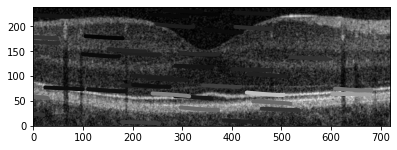

 Average Cost = 9198.020494378841
Generation 12: 40 worms


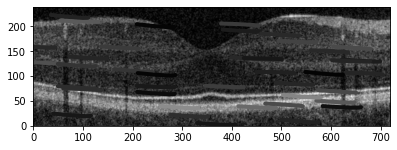

 Average Cost = 10460.938871687798
Generation 13: 40 worms


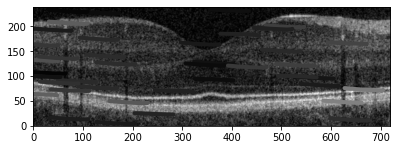

 Average Cost = 10850.579947066695
Generation 14: 40 worms


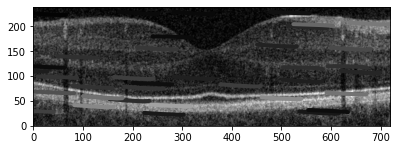

 Average Cost = 11788.053949682664
Generation 15: 40 worms


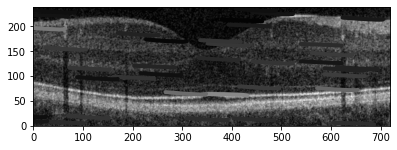

 Average Cost = 11493.917583703542
Generation 16: 40 worms


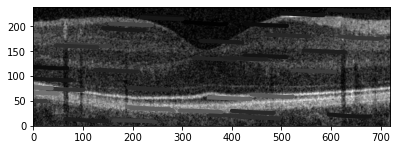

 Average Cost = 10636.102233634
Generation 17: 40 worms


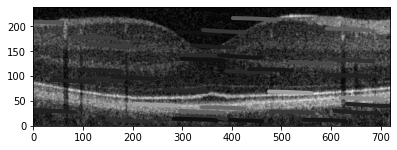

 Average Cost = 10341.799771190452
Generation 18: 40 worms


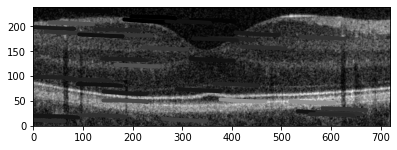

 Average Cost = 9902.065693935216
Generation 19: 40 worms


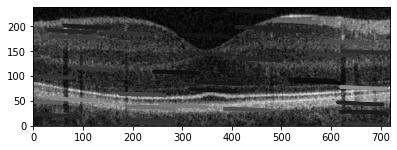

 Average Cost = 12042.09790276825
Generation 20: 40 worms


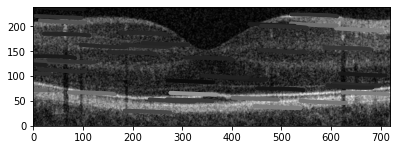

 Average Cost = 11359.508673918654
Generation 21: 40 worms


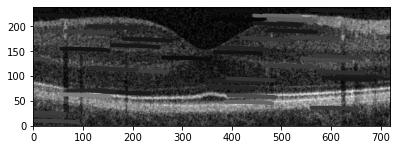

 Average Cost = 10781.432611055337
Generation 22: 40 worms


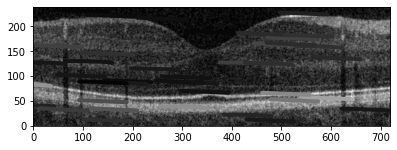

 Average Cost = 10111.144680541867
Generation 23: 40 worms


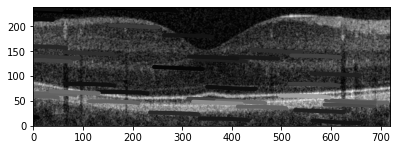

 Average Cost = 11158.026786710467
Generation 24: 40 worms


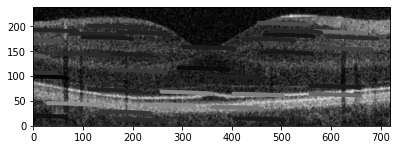

 Average Cost = 11247.81152641325
Generation 25: 40 worms


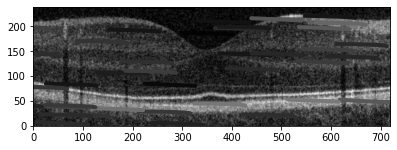

 Average Cost = 11346.226005847886
Generation 26: 40 worms


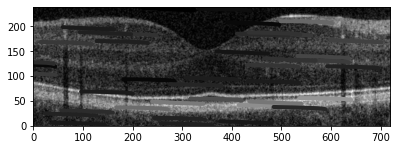

 Average Cost = 10120.94046223269
Generation 27: 40 worms


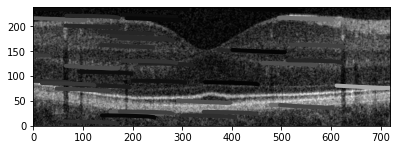

 Average Cost = 9548.358747386135
Generation 28: 40 worms


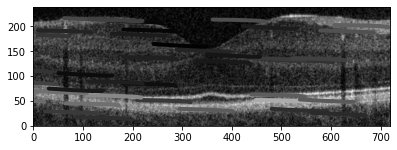

 Average Cost = 10865.78364061406
Generation 29: 40 worms


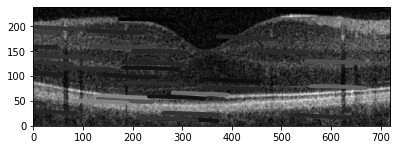

 Average Cost = 10368.816152487228
Generation 30: 40 worms


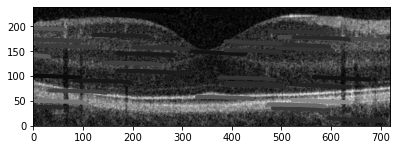

 Average Cost = 11100.89451708578
Generation 31: 40 worms


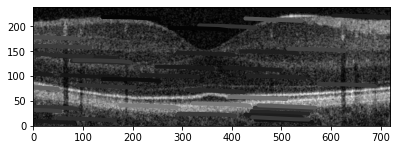

 Average Cost = 10342.768802170562
Generation 32: 40 worms


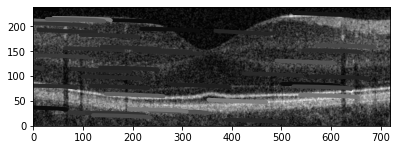

 Average Cost = 10370.977225952936
Generation 33: 40 worms


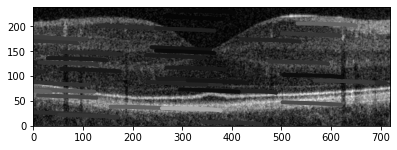

 Average Cost = 10244.205551893725
Generation 34: 40 worms


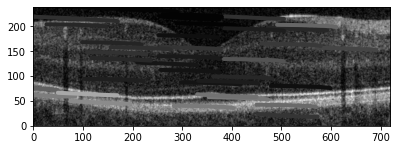

 Average Cost = 8722.757725609012
Generation 35: 40 worms


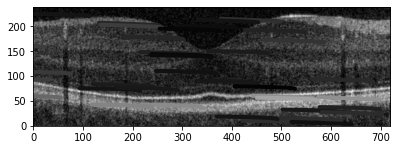

 Average Cost = 10301.756556827739
Generation 36: 40 worms


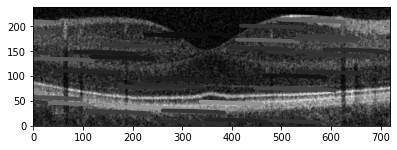

 Average Cost = 11177.460150265144
Generation 37: 40 worms


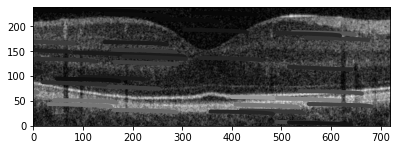

 Average Cost = 10824.819285573582
Generation 38: 40 worms


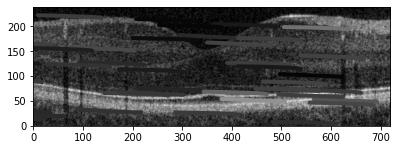

 Average Cost = 11370.40562977068
Generation 39: 40 worms


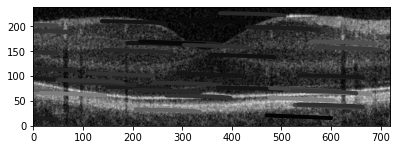

 Average Cost = 10949.700584853503
Generation 40: 40 worms


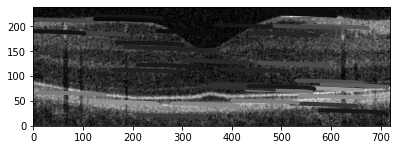

 Average Cost = 9679.131824904622


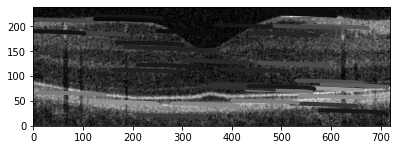

In [14]:
# Run the genetic algorithm
def run_algorithm(image, generations=40):
    population = Worm_Population(POPULATION_SIZE, image.shape)
    for i in range(generations):
        population.evaluate_fitness(image, population.worms)
        population.select()
        population.crossover()
        
        # Update attributes of worms in the population
        for worm in population.worms:
            worm.grow()
            worm.move(image.shape)
            worm.adapt_color(image)
            worm.adapt_curvature()
        
        # Display generation details
        print(f"Generation {i+1}: {len(population.worms)} worms")
        visualize_population(population.worms, image)
        
        # Calculate and display the total cost of the population
        total_cost = 0
        for worm in population.worms:
            cost = calculate_cost(worm, image, population.worms)
            total_cost += cost
        average_cost = total_cost / len(population.worms)
        print(f" Average Cost = {average_cost}")
    
    return population

# Visualize the population of worms
def visualize_population(worms, image):
    drawing = wrm.Drawing(image)
    drawing.add_worms(worms)
    drawing.show()

# Example usage
optimized_population = run_algorithm(image)
drawing = wrm.Drawing(image)
drawing.add_worms(optimized_population.worms)
drawing.show()